In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier

In [2]:
def ssin(t): # Первая функция - синусоида
    noize = np.random.random()-0.5
    return np.sin(3*t) + noize/2

def parab(t): # Вторая функция - перевернутая парабола
    noize = np.random.random()-0.5
    return (-(t-0.3+noize/3)**2 / (1+noize/5))/2+1
    
ssin = np.vectorize(ssin,otypes=[np.float64])
parab = np.vectorize(parab,otypes=[np.float64])

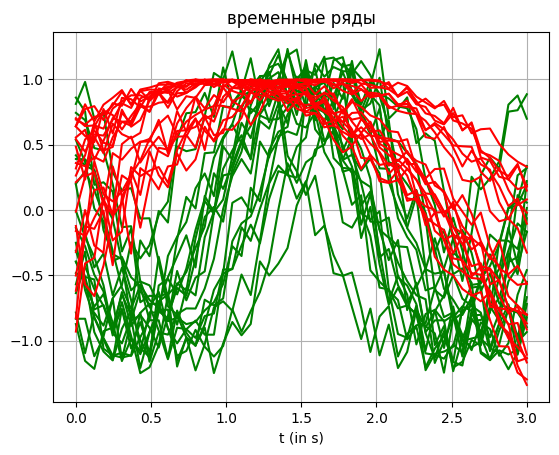

In [3]:
# индекс и отсчет времени в секундах
Tindex = np.linspace(0, 3, 50)

Tser_list = {'Time': Tindex}
N = 20
ser = []
lables = [0]*N
lables.extend([1]*N)


# Создаем список из N рядов обеих функций
for i in range(N):
    temp = ssin(Tindex - np.random.random() - 1/2)
    Tser_list["Te"+str(i)]= temp
    ser.append(temp)

# Парабола
for i in range(N):
    temp = parab(Tindex - np.random.random() - 1/2)
    Tser_list["Tp"+str(i)]= temp
    ser.append(temp)


for i in range(N):
    plt.plot(Tindex, Tser_list["Te"+str(i)], '-g')
for i in range(N):
    plt.plot(Tindex, Tser_list["Tp"+str(i)], '-r')

plt.title(r'временные ряды')
plt.xlabel(r't (in s)')
plt.grid()

Нормализация ряда

In [4]:
def norm(R):
    m = np.mean(R) # Среднее по ряду
    s = np.std(R) # Стандатроне отклонение
    if s > 0.00001: 
        res = (R-m)/s # Приводим к нормальной форме
    else:
        res = R - m
    return res

Определение расстояния между рядами

In [5]:
def dist(R,L):
    R = norm(R) # Нормальные формы обоих рядов
    L = norm(L)
    S = R - L # Вычисляем разницу между соответствующими элементами рядов
    S = S*S # Возводим в квадрат
    res = np.sum(S) # Получаем сумму квадратов разности между рядами
    return res

Извлечение подпоследовательности

In [6]:
def extract_subsequnces(T,lenght):
    res = []
    for i in range(len(T)-lenght+1):
        res.append(T[i:i+lenght]) # Создаем список из всех возможных подп. длины lenght
    return res

Расстояние между временными рядами

In [7]:
def dist_series(R,T):
    Subs = extract_subsequnces(T,len(R)) # Берем все подпоследовательности нужной длины
    distances = np.zeros(len(Subs)) # Задаем пустой массив для расстояний 
    for i,j in enumerate(Subs):
        distances[i] = dist(R,j) # Заполняем массив расстояниями
    res = np.min(distances) # Берем минимальное расстояние 
    return res

Вычисление энтропии ряда по формуле Шеннона

In [8]:
def entropy(T):
    n = len(T)
    if n != 0:
        ones = np.sum(T)
        zeros = n - ones
        res = 0
        if zeros != 0:
            res += -zeros/n*np.log(zeros/n)
        if ones != 0:
            res += -ones/n*np.log(ones/n)
    else:
        res = 0
    return res

Вычисляем качество

In [9]:
def calc_quality(Ds,lables):
    temp = list(zip(Ds,lables)) # Объединяем ряд с лейблами
    temp = sorted(temp,key=lambda x: x[0]) # Сортируем по ряду
    labels = np.array([i[1] for i in temp]) # Возвращаем отсотритрованный ряд лейблов 
    igs = np.zeros(len(labels)) # массив оценок IG
    base = entropy(labels) 
    n = len(labels)
    for i in range(len(temp)):
        igs[i] = base - (i/n*entropy(labels[:i]) + (n-i)/n*entropy(labels[i:])) # Вычисляем количество информации
    res = np.max(igs)
    return res

Удаление одинаковых шейплетов

In [10]:
def remove_similar(shapelets):
    flags = [True]*len(shapelets) # создаем спсиок флажков
    for i in range(len(shapelets)): # Проходим по всем парам шейплетов
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i][0],shapelets[j][0]) < 0.00001:  # Если они совпадают с указанной точностью
                flags[i] = False  # Меняем флажок на False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i) # А затем удаляем повторы
    return shapelets

Добавление шейплета

In [11]:
def add_if_new(shapelets,shap):
    flag = True
    for j in range(len(shapelets)):
            if dist(shap[0],shapelets[j][0]) < 0.0000001: # Проверяем шейплет на наличие копии
                flag = False
                break
    if flag:
         shapelets.append(shap) # Добавляем если копии нет
    return flag

In [12]:
dataset = list(zip(ser,lables)) # Объединяем списки ВР и отметки об исходных функциях

random.seed(666)

random.shuffle(dataset) # Перемешиваем датасет

train = dataset[:N*16//10] # делим на тестовую и тренировочную выборки
test = dataset[N*16//10:]

train_ser = [i[0] for i in train] # А затем делим выборки на сами TS и соответствующие лейблы
train_labels = [i[1] for i in train]
test_ser = [i[0] for i in test]
test_labels = [i[1] for i in test]

In [13]:
origin_ser = ser # Меняем имена
origin_lables = lables
ser = train_ser
lables = train_labels

In [14]:
#Ограничения длины шапилетов
min_len = 5
max_len = 25

#Кол-во шейплетов, которое достается из каждого обучающего ряда
p = 5

#найденные шейплеты по длинам
rShapeles = {}
for i in range(min_len,max_len+1):
    rShapeles[i] = []

for d,i in enumerate(ser):
    print(f"{d+1}/{len(ser)}")
    shapelets = []
    #Достаем все шейплеты из ряда и оцениваем их
    for j in range(min_len,max_len+1):
        sh_same_lenght = []
        W = extract_subsequnces(i,j)
        for k in W:
            Ds = np.zeros(len(ser))
            for z,f in enumerate(ser):
                Ds[z] = dist_series(k,f)
            quality = calc_quality(Ds,lables)
            sh_same_lenght.append((k,quality))
        #Удаляем потворы
        sh_same_lenght = remove_similar(sh_same_lenght)
        shapelets.extend(sh_same_lenght)
    #Сортируем шейплеты по качеству и добавляем только p лучших (если они уже не добавлены из прошлых рядов)
    shapelets = sorted(shapelets,key=lambda x: x[1],reverse=True)
    s = 0
    j = 0
    while j < len(shapelets) and s < p:
        if add_if_new(rShapeles[len(shapelets[j][0])],shapelets[j]):
            s += 1
        j += 1

SH = list(rShapeles.values())

1/32
2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32


In [15]:
SH = []
qualities = []

for i in rShapeles.keys():
    for j in rShapeles[i]:
        SH.append(j[0]) # Объединяем все шейплеты в единый список
        qualities.append(j[1]) # Как и их качество

Вычисляем рассотояние от шейплетов до временного ряда

In [16]:
def constract_features_vector(T,shapelets):
    D = np.zeros(len(shapelets))
    for i in range(len(shapelets)):
        D[i] = dist_series(shapelets[i],T)
    return D

In [17]:
train_features = [constract_features_vector(i,SH) for i in train_ser]
test_features = [constract_features_vector(i,SH) for i in test_ser]

In [18]:
clf = RandomForestClassifier(30)
clf.fit(train_features,train_labels)

RandomForestClassifier(n_estimators=30)

In [19]:
print("Итоги обучения")
print(f"Train accuracy={clf.score(train_features,train_labels)}")
print(f"test accuracy={clf.score(test_features,test_labels)}")
# print(f"Train labels={train_labels}, train predict={clf.predict(train_features)}, test labels={test_labels}, test predict={clf.predict(test_ser)}")

Итоги обучения
Train accuracy=1.0
test accuracy=1.0


In [20]:
print("Найденные шейплеты и их IG")
for i in zip(SH,qualities):
    print(f"shapelet={i[0]} IG={i[1]}")

Найденные шейплеты и их IG
shapelet=[-0.8779743  -0.59737277 -0.65358148 -0.20860538 -0.01169555  0.31529418] IG=0.6911927820032008
shapelet=[-0.93447658 -0.73776939 -0.84559582 -0.54721496 -0.43252826 -0.16570812] IG=0.6911927820032008
shapelet=[-0.03852583  0.50503576  0.56214265  0.36384313  0.47392259  0.56137387
  0.45940284  0.75802491] IG=0.6911927820032008
shapelet=[-0.68891821 -0.74879275 -0.85132423 -0.82398765 -0.87373492 -0.85717296
 -0.76912881 -0.7063198 ] IG=0.6911927820032008
shapelet=[-0.88539685 -0.67604179 -0.57549514 -0.24694592 -0.3702898  -0.26886888
 -0.03742902  0.06435253  0.54491265] IG=0.6911927820032008
shapelet=[-0.57313884 -0.94187862 -1.13320369 -0.92682496 -1.20629195 -1.16195248
 -0.99597009 -1.03745497 -0.76949023] IG=0.6911927820032008
shapelet=[-0.9837893  -1.03815545 -0.8760844  -0.61190928 -0.48572957  0.05509656
  0.09736898 -0.0149333   0.52464881] IG=0.6911927820032008
shapelet=[-0.52472832 -0.93511998 -1.08401048 -1.15162996 -0.90948412 -0.7700

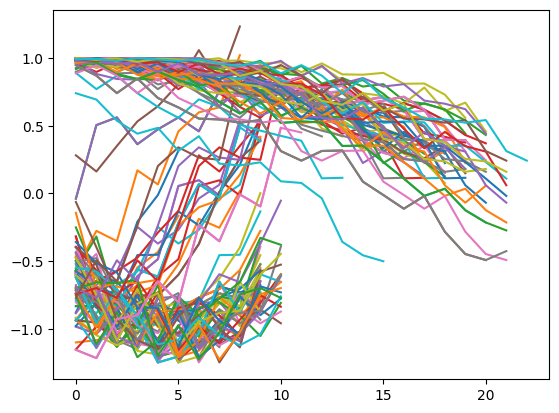

In [21]:
for i in SH:
    plt.plot(i)